In [1]:
from collections import deque
import matplotlib.pyplot as plt

In [2]:
# import classical libraries
%matplotlib inline
%pylab inline

# avoid warnings
import warnings
warnings.filterwarnings("ignore")

# figure size
rcParams['figure.figsize'] = (16, 9)

# print only 2 decimals
set_printoptions(precision=2)

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Lorenz-63 dynamical model
def Lorenz_63(x, dx, sigma, rho, beta):
    dx = zeros((3))
    dx[0] = sigma*(x[1]-x[0])
    dx[1] = x[0]*(rho-x[2])-x[1]
    dx[2] = x[0]*x[1] - beta*x[2]
    return dx

In [22]:
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

# define the parameters
x0 = array([8,0,30]) # initial condition
dt = 0.001 # integration time step
T = 100 # number of Lorenz-63 times
sigma = 10
rho = 28
beta = 8/3

# generate the Lorenz-63 system
x = odeint(Lorenz_63, x0, arange(0.01,T,dt), args=(sigma, rho, beta))
time = arange(0.01, T, dt)

In [23]:
np.shape(x)

(99990, 3)

In [25]:
(T-dt)/dt

99999.0

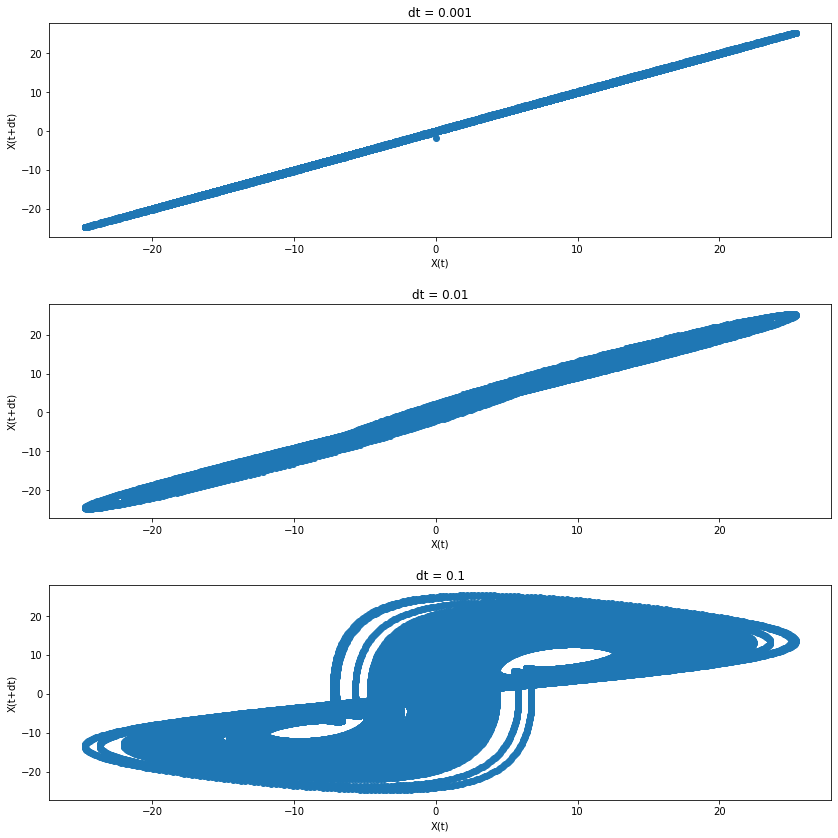

In [5]:
dt_vec = [0.001, 0.01, 0.1]

i = 1

x_ = odeint(Lorenz_63, x0, arange(0.01,T,dt), args=(sigma, rho, beta))

fig = plt.figure(figsize=(12,12))

for dt in dt_vec:
    
    xtplus = deque(x[:,1])
    xtplus.rotate(int(dt/dt_vec[0]))

    xtplus = np.array(list(xtplus))
    np.shape(xtplus)
    
    subplot(3,1,i)
    plt.scatter(x[:,1],xtplus)
    plt.title('dt = '+str(dt))
    plt.xlabel('X(t)')
    plt.ylabel('X(t+dt)')
    i += 1
    
fig.tight_layout(pad = 2)

## GAN implementation

In [6]:
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.optimizers import Adam

Using TensorFlow backend.


In [7]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=16,input_dim=3, activation='selu'))
    
    generator.add(Dense(units=16, activation='selu'))
    
    generator.add(Dense(units=3, activation='selu'))
    
    generator.compile(loss='mean_squared_error', optimizer='adam')
    return generator
g=create_generator()
g.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                64        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 51        
Total params: 387
Trainable params: 387
Non-trainable params: 0
_________________________________________________________________


In [8]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=16,input_dim=3, activation='selu'))
    
    discriminator.add(Dense(units=16, activation='selu'))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer='adam')
    return discriminator
d=create_discriminator()
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                64        
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


In [9]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(3,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 3)                 387       
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 353       
Total params: 740
Trainable params: 387
Non-trainable params: 353
_________________________________________________________________


In [66]:
def generate_data(N):
    
    #Model parameters
    dt = 0.001 # integration time step
    T = 1 # number of Lorenz-63 times
    sigma = 10
    rho = 28
    beta = 8/3
    l = int((T-dt)/dt)

    X = np.zeros((N,l,3))
    
    for n in range(N):    

        x0 = [np.random.randn(), np.random.randn(), np.random.randn()]

        # generate the Lorenz-63 system
        x = odeint(Lorenz_63, x0, arange(dt,T,dt), args=(sigma, rho, beta))
        X[n,...] = x
    return X

In [67]:
N = 10
X = generate_data(N)

X_train = X[:int(0.7*N)]
X_test = X[int(0.7*N):]

In [68]:
_ = 0
real_trajectory = X_train[2*_:2*_+2,:] 
np.shape(real_trajectory)

(2, 999, 3)

In [64]:
batch_size = 2
noise= np.random.normal(0,1, [batch_size*N, 3])

generator= create_generator()
generated_trajectory = generator.predict(noise).reshape(batch_size,N,3)

np.shape(generated_trajectory)

(2, 10, 3)

In [76]:
def training(X_train, epochs=1, batch_size=128):

    #Loading the data
    #batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
            
            # Real trajectories
            real_trajectory = X_train[batch_size*_:batch_size*_+batch_size,:]
            
            N = np.shape(real_trajectory)[1]
            
            #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size*N, 3])
 
            generated_trajectory = generator.predict(noise).reshape(batch_size,N,3)
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([real_trajectory, generated_trajectory], axis=1)
            
            print(np.shape(X))
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]= 1 #0.9bat
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            #noise= np.random.normal(0,1, [batch_size, T])
            #y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            #discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            #gan.train_on_batch(noise, y_gen)
            
        #if e == 1 or e % 20 == 0:
           
             #plot_generated_images(e, generator)
training(X_train,1,2)



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1
(2, 1998, 3)


ValueError: Error when checking input: expected dense_103_input to have 2 dimensions, but got array with shape (2, 1998, 3)

In [19]:
noise= np.random.normal(0,1, [2, 100])
np.shape(noise)

(2, 100)

In [12]:
y_dis=np.zeros(2*128)
y_dis[:128]=0.9

In [15]:
y_dis[-1]

0.0